## Expected Free Energy minimization for mobile robot navigation

Wouter Kouw, last update: 30-12-2022

### Dynamics

Consider a mobile robot that moves according to:

$$\underbrace{\begin{bmatrix} c_{x,k} \\ c_{y,k} \\ \dot{c}_{x,k} \\ \dot{c}_{y,k} \end{bmatrix}}_{z_k} = \underbrace{\begin{bmatrix} 1 & 0 & \Delta t & 0 \\ 0 & 1 & 0 & \Delta t \\ 0 & 0 & 1 & 0 \\ 0 & 0 & 0 & 1 \end{bmatrix}}_{A} \underbrace{\begin{bmatrix} c_{x,k-1} \\ c_{y,k-1} \\ \dot{c}_{x,k-1} \\ \dot{c}_{y,k-1} \end{bmatrix}}_{z_{k-1}} + \underbrace{\begin{bmatrix} 0 & 0 \\ 0 & 0 \\ \Delta t & 0 \\ 0 & \Delta t \end{bmatrix}}_{B} \underbrace{\begin{bmatrix} u_{x,k} \\ u_{y,k}\end{bmatrix}}_{u_k} + q_k \, .$$

Process noise is white, $q_k \sim \mathcal{N}(0, Q)$, with 

$$Q = \begin{bmatrix} \frac{\Delta t^3}{3} \rho_x & 0 & \frac{\Delta t^2}{2} \rho_x & 0 \\
                      0 & \frac{\Delta t^3}{3} \rho_y & 0 & \frac{\Delta t^2}{2} \rho_y \\
                      \frac{\Delta t^2}{2} \rho_x & 0 & \Delta t \rho_x & 0 \\
                      0 & \frac{\Delta t^2}{2} \rho_y & 0 & \Delta t \rho_y \end{bmatrix} \, .$$

### Observations: trilateration

The robot positions itself in space using triangulation with respect to two beacons, $\beta_1$ and $\beta_2$. The positions of the beacons are known and they report the angle of the robot as follows:


The measurements are $y = [\alpha_1 \ \alpha_2]^{\top}$. As such, we have a likelihood function of the form:

$$\begin{align}
\alpha_1 &= \arccos\big(\frac{d_1^2 + L^2 - d_2^2}{2d_1 L} \big) \\
\alpha_2 &= \arccos\big(\frac{d_2^2 + L^2 - d_1^2}{2d_2 L} \big)
\end{align}$$

where $L$ is the distance between the beacons, $L = \|\beta_1 - \beta_2\|_2$, and $d_1$,$d_2$ are the distances to each of the beacons: $d_1 = \| x_k - \beta_1\|_2$ and $d_2 = \| x_k - \beta_2\|_2$. We denote this as:

$$y_k = g(x_k) + r_k$$

where $r_k$ is measurement noise caused by angle measurements and communication between the beacons and the robot.

$$

### Probabilistic model

The above system can be captured with a probabibilistic state-space model of the form:

$$\begin{align}
p(z_0) &= \mathcal{N}(z_0 \mid m_0, S_0) \\
p(z_k \mid z_{k-1}, u_k) &= \mathcal{N}(z_k \mid Az_{k-1} + Bu_k, Q) \\
p(y_k \mid z_k) &= \mathcal{N}(y_k \mid g(z_k), R) \, .
\end{align}$$

We can simulate the behaviour of this system as follows:

In [1]:
using Pkg
Pkg.activate(".")
Pkg.instantiate()

  Activating project at `~/syndr/Wouter/Onderzoek/Projecten/tue/efe-planning/FRAI2023-nlamb`


In [9]:
using Colors
using Optim
using ForwardDiff
using ProgressMeter
using LinearAlgebra
# using ControlSystems
using Distributions
using Plots
default(label="", grid=false, linewidth=3, markersize=3, margin=15Plots.pt)

In [10]:
include("util.jl");

In [21]:
# Temporal variables
Δt = 0.02
len_time = 100
time = range(0, step=Δt, length=len_time)

# Matrices
A = [1. 0. Δt 0.;
     0. 1. 0. Δt;
     0. 0. 1. 0.;
     0. 0. 0. 1.]
B = [0. 0.;
     0. 0.;
     Δt 0.;
     0. Δt]

# Process noise
σx = 1e-4
σy = 1e-4
Q = [Δt^3/3*σx         0.  Δt^2/2*σx        0.;
        0.     Δt^3/3*σy          0. Δt^2/2*σy;
    Δt^2/2*σx         0.       Δt*σx        0.;
        0.     Δt^2/2*σy          0.    Δt*σy;]

# Beacon coordinates
β1 = [-1., 0.]
β2 = [ 1., 0.];
β3 = [ 0., 1.];

# Nonlinear observation
function g(x)
    
    rA = sqrt((x[1] - β1[1])^2 + (x[2] - β1[2])^2)
    rB = sqrt((x[1] - β2[1])^2 + (x[2] - β2[2])^2)
    rC = sqrt((x[1] - β3[1])^2 + (x[2] - β3[2])^2)
    
    return [rA,rB,rC]
end

# Measurement noise
R = 1e-3*diagm(ones(3));

In [22]:
function update(z_kmin1, u_k)
   "Update environment" 
    
    # State transition
    z_k = rand(MvNormal(A*z_kmin1 + B*u_k, Q))
    
    # Emit noisy observation
    y_k = rand(MvNormal(g(z_k), R))
    
    return y_k, z_k
end;

In [23]:
# Setpoint (desired observation)
z_star = [0., -1.0, 0.0, 0.0]
y_star = g(z_star)

3-element Vector{Float64}:
 1.4142135623730951
 1.4142135623730951
 2.0

In [24]:
# Initial state
z_0 = [-1.0, -2.0, 0.0, 0.0]

# Preallocate
z = zeros(4,len_time)
y = zeros(3,len_time)

# Test control
u = rand(2,len_time)

# Start recursion
z_kmin1 = z_0
for k in 1:len_time
    
    # Update system
    y[:,k], z[:,k] = update(z_kmin1, u[:,k])
    
    # Update recursion
    z_kmin1 = z[:,k]
    
end

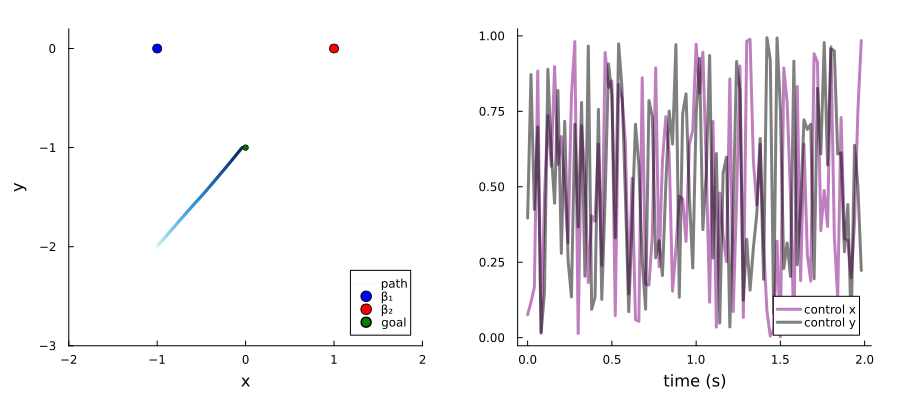

In [25]:
p1 = plot(z[1,:], z[2,:], c=colormap("Blues"), xlabel="x",ylabel="y", xlims=(-2, 2), ylims=(-3, 0.2), label="path")
scatter!([β1[1]], [β1[2]], color="blue", label="β₁", markersize=5)
scatter!([β2[1]], [β2[2]], color="red", label="β₂", markersize=5)
scatter!([z_star[1]], [z_star[2]], color="green", label="goal", markersize=3)
p2 = plot(time, u[1,:], color="purple", xlabel="time (s)", alpha=0.5, label="control x")
plot!(time, u[2,:], color="black", xlabel="time (s)", alpha=0.5, label="control y")

plot(p1, p2, layout=(1,2), size=(900,400))

## Expected Free Energy

From the agent's viewpoint, the evolution of these future variables are constrained by its generative model, rolled out into the future:
$$\begin{aligned}
p(y,z,u) &= \underbrace{q(z_{k})}_{\substack{\text{current}\\ \text{state}}} \cdot \underbrace{\prod_{t=k+1}^{k+T} p(y_t|z_t) \cdot p(z_t | z_{t-1}, u_t) p(u_t)}_{\text{generative model roll-out to future}} \, ,
\end{aligned}$$

where $y = (y_t, \dots, y_T)$, $z = (z_{t-1}, \dots, z_T)$ and $u = (u_t, \dots, u_T)$. 

Consider the varational free energy functional for estimating posterior beliefs $q(z,u)$ over future states and control signals, with an expectation over future observations $q(y \mid z)$: 

$$\begin{aligned}
H[q] &= \overbrace{\iint q(y \mid z)}^{\text{marginalize }y} \bigg( \overbrace{\int q(z,u) \log \frac{q(z,u)}{p(y,z,u)} }^{\text{variational free energy}}\bigg) \mathrm{d}u \, \mathrm{d}y \, \mathrm{d}z \\
&= \int q(y,z,u) \log \frac{q(z,u)}{p(y,z,u)} \mathrm{d}u \, \mathrm{d}y \, \mathrm{d}z \\
&= \int q(y,z|u) q(u) \log \frac{q(z|u) q(u)}{p(y,z|u) p(u)} \mathrm{d}u \, \mathrm{d}y \, \mathrm{d}z \\
&= \int q(u) \bigg(\sum_{y,z} q(y,z|u) \log \frac{q(s|u) q(u)}{p(y,z|u) p(u)}\bigg) \mathrm{d}u \, \mathrm{d}y \, \mathrm{d}z \\
&= \int q(u) \bigg( \log q(u) + \log \frac{1}{p(u)}+ \underbrace{q(y,z|u) \log \frac{q(z|u)}{p(y,z|u)}}_{G(u)}\bigg) \mathrm{d}u \, \mathrm{d}y \, \mathrm{d}z \\
&= \int q(u) \log \frac{q(u)}{p(u)\exp\left(- G(u)\right) } \mathrm{d}u  \, .
\end{aligned}$$

We can recognize a KL-divergence between $q(u)$ and the function $p(u)\exp\left(- G(u)\right)$, which will be minimal when $q(u) = p(u)\exp\left(- G(u)\right)$. The $G$ function is known as the _Expected Free Energy_. Let's look at it in detail for a future observation $t$,

$$ G(u_t) = \iint q(y_t, z_t \mid u_t) \log \frac{q(z_t \mid u_t)}{p(y_t, z_t \mid u_t)} \mathrm{d}y_t \, \mathrm{d}z_t \, ,$$

where 

$$\begin{aligned}
% q(y_t \mid z_t) &= \mathcal{N}(y_t \mid Cz_t, R) \\
% q(z_t \mid u_t) &= \int p(z_t \mid z_{t-1}, u_t) q(z_{t-1}) \mathrm{d}z_{t-1} \\
% &= \mathcal{N}(z_t \mid A m_{t-1} + Bu_t, AS_{t-1}A^{\top} + Q) \\
p(y_t, z_t \mid u_t) &= \int p(y_t \mid z_t) p(z_t \mid z_{t-1}, u_t) q(z_{t-1}) \mathrm{d}z_{t-1} \\
&= \mathcal{N}(\begin{bmatrix} y_t \\ z_t \end{bmatrix} \mid \begin{bmatrix} C(A m_{t-1} + Bu_t) \\ A m_{t-1} + Bu_t \end{bmatrix}, \begin{bmatrix} C(AS_{t-1}A^{\top} + Q) C^{\top} + R & C(AS_{t-1}A^{\top} + Q) \\ (AS_{t-1}A^{\top} + Q)C^{\top} & AS_{t-1}A^{\top} + Q \end{bmatrix}) \, ,
\end{aligned}$$

with the approximate posterior for the previous state $q(z_{t-1}) = \mathcal{N}(z_{t-1} \mid m_{t-1}, S_{t-1})$. The distribution $q(z_t \mid u_t)$ is constructed from the state transition:

$$q(z_t \mid u_t) = \int p(z_t \mid z_{t-1}, u_t) q(z_{t-1}) \mathrm{d}z_{t-1} = \mathcal{N}(z_t \mid A m_{t-1} + Bu_t, AS_{t-1}A^{\top} + Q) \, ,$$

and $q(y_t, z_t \mid u) = p(y_t \mid z_t) q(z_t \mid u_t)$ which is equivalent to $p(y_t, z_t \mid u_t)$ in this case. Note that - during planning and in linear Gaussian models - we can drive the KL-divergence between the approximate posteriors $q$ and the true posteriors $p$ to 0, thus allowing us to swap $q$ for $p$.

We will decompose this EFE function into ambiguity plus risk terms (see [lecture slides](https://nbviewer.org/github/bertdv/BMLIP/blob/master/lessons/notebooks/Intelligent-Agents-and-Active-Inference.ipynb) for more detail). To do so, we will decompose $p(y_t,z_t \mid u_t)$ into $p^\prime(y_t)p(z_t|y_t,u_t)$ where $p\prime(y_t)$ is a distribution over the goal state, a.k.a. a _goal prior_; $p^\prime(y) = \mathcal{N}(y \mid m_*, s_*)$. The derivation goes as follows:

$$\begin{aligned}
G(u_t) &= \int  q(y_t,z_t|u_t) \log \frac{q(z_t|u_t)}{p^\prime(y_t)p(z_t|y_t,u_t)} \, \mathrm{d}y_t \, \mathrm{d}z_t \\
&= \int  q(y_t, z_t \mid u_t) \log \frac{q(z_t \mid u_t)}{p^\prime(y_t)} \frac{1}{p(z_t \mid y_t, u_t)} \, \mathrm{d}y_t \, \mathrm{d}z_t \\
&= \int  q(y_t, z_t \mid u_t) \log \frac{q(z_t \mid u_t)}{p^\prime(y_t)} \frac{p(y_t \mid u_t)}{p(y_t \mid z_t)p(z_t \mid u_t)} \, \mathrm{d}y_t \, \mathrm{d}z_t \\
&= \int  q(y_t,z_t|u_t) \log \frac{q(z_t|u_t)}{p(y_t|z_t)p(z_t|u_t)} \frac{p(y_t|u_t)}{p^\prime(y_t)} \, \mathrm{d}y_t \, \mathrm{d}z_t \\
&= \int  q(y_t,z_t|u_t) \log \frac{q(z_t|u_t)}{p(y_t|z_t)p(z_t|u_t)} \, \mathrm{d}z_t \, \mathrm{d}y_t + \int q(y_t,z_t|u_t) \log \frac{p(y_t|u_t)}{p^\prime(y_t)} \, \mathrm{d}y_t \, \mathrm{d}z_t \\
&= \int  p(z_t|u_t) p(y_t|z_t) \log \frac{1}{p(y_t|z_t)} \, \mathrm{d}z_t \, \mathrm{d}y_t + \int p(z|u) p(y|z) \log \frac{p(y_t|u_t)}{p^\prime(y_t)} \, \mathrm{d}z_t \, \mathrm{d}y_t \\
&= \underbrace{\int  p(z_t|u_t) \int p(y_t|z_t) \log \frac{1}{p(y_t|z_t)} \, \mathrm{d}z_t \, \mathrm{d}y_t}_{\text{ambiguity}} + \underbrace{\int p(y_t|u_t) \log \frac{p(y_t|u_t)}{p^\prime(y_t)} \, \mathrm{d}y_t}_{\text{risk}} \ \, ,
\end{aligned}$$

Ambiguity is an expectation over an entropy, which - in the case of a Gaussian likelihood - is actually independent of the state,

$$\int p(y_t|z_t) \log p(y_t|z_t) \mathrm{d}y_t = \frac{1}{2}\big(\log 2\pi R - 1\big) \, ,$$

so the expectation over $p(z_t|u_t)$ doesn't even apply. As you may have noticed, the control $u_t$ doesn't affect ambiguity which means there is no information-seeking behaviour in linear Gaussian state-space models.

The risk term is a KL-divergence between the Gaussian,

$$\begin{aligned}
    p(y_t|u_t) &= \int p(y_t, z_t \mid u_t) \, \mathrm{d}z_t  \\
    &= \int \mathcal{N}(\begin{bmatrix} y_t \\ z_t \end{bmatrix} \mid \begin{bmatrix} C(A m_{t-1} + Bu_t) \\ A m_{t-1} + Bu_t \end{bmatrix}, \begin{bmatrix} C(AS_{t-1}A^{\top} + Q) C^{\top} + R & C(AS_{t-1}A^{\top} + Q) \\ (AS_{t-1}A^{\top} + Q)C^{\top} & AS_{t-1}A^{\top} + Q \end{bmatrix}) \, \mathrm{d}z_t \\
    &= \mathcal{N}(y_t \mid C(A m_{t-1} + Bu_t) , C(AS_{t-1}A^{\top} + Q) C^{\top} + R) \, ,
    \end{aligned}$$
    
and the goal prior $p^\prime(y_t)$. The formula for the KL-divergence between two Gaussians is (see [wiki](https://en.wikipedia.org/wiki/Kullback%E2%80%93Leibler_divergence#Multivariate_normal_distributions)):

$$\begin{aligned}
D_{\text{KL}}( \mathcal{N}(x \mid m_1, \sigma_1) || \mathcal{N}(x \mid m_2, \sigma_2) ) = \frac{1}{2} \Big[\log\frac{|\Sigma_2|}{|\Sigma_1|} - d + \text{tr}(\Sigma_2^{-1}\Sigma_1) + (\mu_2 - \mu_1)^{\top}\Sigma_2^{-1}(\mu_2 - \mu_1) \Big] \, .
\end{aligned}$$

For our distribution, this becomes:

$$\int p(y_t|u_t) \log \frac{p(y_t|u_t)}{p^\prime(y_t)} \, \mathrm{d}y_t = \frac{1}{2} \Big[\log\frac{s_*}{|C(AS_{t-1}A^{\top} + Q) C^{\top} + R|} - 1 + \text{tr}(\frac{(C(AS_{t-1}A^{\top} + Q) C^{\top} + R)}{s_*}) + \frac{\big(m_* - (C(A m_{t-1} + Bu_t))\big)^2}{s_*}) \Big]$$


The decomposition is the same for any future state $t$. We may thus unroll the policy as $G(u) = \sum_{t=k+1}^{TT} G(u_t)$.

---

The above equations can be written down to form an objective function.

In [26]:
function ambiguity(Σ,Γ,S)
   return 0.5(log(2π) + logdet(Σ - Γ'*inv(S)*Γ) - 1) 
end

ambiguity (generic function with 1 method)

In [14]:
# function risk(μ, Σ, goal)
#     "Naive version"
#     m_star, S_star = goal
#     iS = inv(S_star)
#     return 0.5(log(det(S_star)/det(Σ)) + length(m_star) + (μ-m_star)'*iS*(μ-m_star) + tr(iS*Σ))
# end

function risk(μ, Σ, goal)
    "Numerically improved version"
    
    m_star, S_star = goal
    k = length(m_star)
    
    L0 = cholesky(Σ).L
    L1 = cholesky(S_star).L
    
    M = inv(L1)*L0
    y = inv(L1)*(m_star - μ)
    
    return 0.5(sum(M[:].^2) - k + norm(y,1).^2 + 2*sum([log(L1[i,i]./L0[i,i]) for i in 1:k]))
end

risk (generic function with 1 method)

In [ ]:
function EFE(u::AbstractVector, 
             state::Tuple{Vector{Float64}, Matrix{Float64}}, 
             goal::Tuple{Float64,Float64}; 
             s_u::Float64=1.0,
             time_horizon::Int64=1)
    "Expected Free Energy"
    
    # Unpack parameters of current state
    m_tmin1, S_tmin1 = state
    
    # Start cumulative sum
    cEFE = 0.0
    for t in 1:time_horizon
        
        # State transition p(z_t | u_t)
        m_t = A*m_tmin1 + B*u[(t-1)*2+1:2t]
        S_t = A*S_tmin1*A' + Q

        # Unscented transform moments
        μ, Σ, Γ = ET2(m_t, S_t, g, addmatrix=R)
        
        # Cumulate EFE
        cEFE += ambiguity(Σ,Γ,S) + risk(μ,Σ,goal) + 1/(s_u)*u[t]^2
        
        # Update state recursion
        m_tmin1 = m_t
        S_tmin1 = S_t
                
    end
    return cEFE
end

We can use the Optim.jl library to auto-differentiate EFE and minimize it every time step.

In [ ]:
len_trial = 50
time = range(0, step=Δt, length=len_trial)

# Time horizon
len_horizon = 5;

In [ ]:
# Distribution around goal state
goal = (y_star, 1e-3*diagm(ones(2)))

# Limits of controller
u_lims = (-10.0, 10.0)

# Preallocate
z_est = (zeros(4,len_trial), zeros(4,4,len_trial))
z_sim = zeros(4,len_trial)
y_sim = zeros(2,len_trial)
u_sim = zeros(2,len_trial)

# Initial belief
m_0 = zeros(4)
S_0 = diagm(ones(4))

# Actual initial state
z_sim[:,1] = z_0

# Start recursion
m_kmin1 = m_0
S_kmin1 = S_0

# Initialize policy
policy = zeros(len_horizon)

@showprogress for k in 2:len_trial
    
    "Interact with environment"
    
    # Update system with selected control
    y_sim[:,k], z_sim[:,k] = update(z_sim[:,k-1], u_sim[:,k-1])
   
    "State estimation"
    
    # Prediction step
    m_k_pred = A*m_kmin1 + B*u_sim[:,k-1]
    S_k_pred = A*S_kmin1*A' .+ Q
    
    # Correction step
    μ, Σ, Γ = ET2(m_k_pred, S_k_pred, g, addmatrix=R)
    m_k = m_k_pred .+ Γ*inv(Σ)*(y_sim[:,k] - μ)
    S_k = S_k_pred .- Γ*inv(Σ)*Γ'
    
    # Store state estimates
    z_est[1][:,k] = m_k
    z_est[2][:,:,k] = S_k
    
    "Planning"
    
    # Single-argument objective
    G(u::AbstractVector) = EFE(u, (m_k,S_k), goal, s_u=1e6, time_horizon=len_horizon)
    
    # Call minimizer using constrained L-BFGS procedure
    results = Optim.optimize(G, u_lims[1], u_lims[2], policy, Fminbox(LBFGS()); autodiff=:forward)
    
    # Extract minimizing control
    policy = Optim.minimizer(results)
    u_sim[:,k] = policy[1:2]
   
    # Update recursion
    m_kmin1 = m_k
    S_kmin1 = S_k
    
end

In [ ]:
p301 = plot(time, z_sim[1,:], label="true", ylabel="Position", xlabel="Time [s]")
scatter!(time, y_sim, label="observations", color="black")
plot!(time, z_est[1][1,:], ribbon=sqrt.(z_est[2][1,1,:]), label="inferred", color="purple")
plot!(time, y_star*ones(len_trial), color="green", linestyle=:dash, label="setpoint")
plot!(time, z_star[1]*ones(len_trial), color="darkgreen", linestyle=:dot, label="goal observation")
p302 = plot(time, u_sim, color="red", ylabel="Control")
plot(p301, p302, layout=(2,1), size=(900,500))

### Visualization

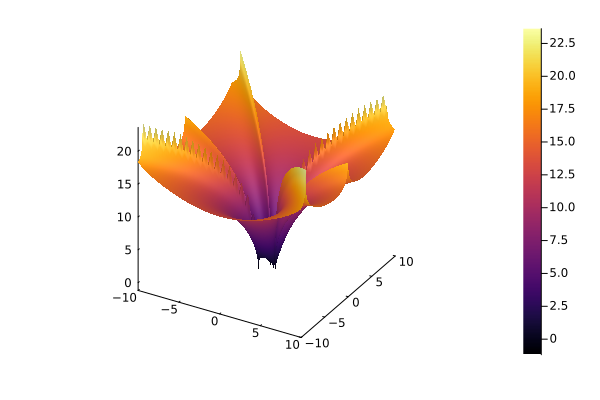

In [30]:
# Plot ambiguity over state-space

num_grid = 300
xgrid = range(-10, 10, length=num_grid)
ygrid = range(-10, 10, length=num_grid)

function helper(x,y; S=diagm(ones(4)))
    μ, Σ, Γ = ET2([x,y,0.,0.], S, g)
    return -ambiguity(Σ,Γ, S)
end

# contourf(xgrid, ygrid, helper, c=colormap("Blues"), levels=100, linewidth=0, tickfontsize=15, size=(700,500))
surface(xgrid, ygrid, helper)

In [ ]:
savefig("figures/trilaterion-ambiguity-statespace.png")

In [ ]:
# Plot risk over state-space

num_grid = 100
xgrid = range(-1.2, 1.2,length=num_grid)
ygrid = range(-2.1,-0.1,length=num_grid)

function helper(x,y; goal=(y_star, diagm(1e-1*ones(2))), S=diagm(1e-2ones(4)))
    
    m_star, S_star = goal
    μ, Σ, Γ = ET2([x,y,0.,0.], S, g, addmatrix=1e-8*diagm(ones(2)))
    
    return risk(μ, Hermitian(Σ), goal)
end

contourf(xgrid, ygrid, helper, c=colormap("Blues"), levels=200, linewidth=0, size=(700,500))
scatter!([z_star[1]], [z_star[2]], color="black", markersize=10, tickfontsize=15)

In [ ]:
savefig("figures/risk-statespace.png")

In [ ]:
# Plot both ambiguity and risk over state-space

num_grid = 100
xgrid = range(-1.1, 1.1,length=num_grid)
ygrid = range(-2.1,-0.1,length=num_grid)

function helper(x,y; goal=(y_star, diagm(1e-1*ones(2))), S=diagm(1e-2ones(4)))
    
    m_star, S_star = goal
    μ, Σ, Γ = ET2([x,y,0.,0.], S, g, addmatrix=1e-8*diagm(ones(2)))
    
    return ambiguity(Σ,Γ,S) + risk(μ, Hermitian(Σ), goal)
end

contourf(xgrid, ygrid, helper, c=colormap("Blues"), levels=200, linewidth=0, size=(1400,500))
scatter!([z_star[1]], [z_star[2]], color="black", markersize=10, tickfontsize=15)

In [ ]:
savefig("figures/risk+ambiguity-statespace.png")

In [ ]:
len_trial = 30
time = range(0, step=Δt, length=len_trial)

# Time horizon
len_horizon = 5;

In [ ]:
function planned_trajectory(policy, current_state)
    "Generate future states and observations"
    
    # Extract time horizon
    time_horizon = length(policy)
    
    # Unpack parameters of current state
    m_tmin1, S_tmin1 = current_state
    
    # Track predicted observations
    z_m = zeros(2,time_horizon)
    z_S = zeros(2,2,time_horizon)
    y_m = zeros(time_horizon)
    y_v = zeros(time_horizon)
    
    for t in 1:time_horizon
        
        # State transition
        z_m[:,t] = A*m_tmin1 + B*policy[t]
        z_S[:,:,t] = A*S_tmin1*A' + Q
        
        # Predicted observations
        y_m[t],y_v[t],_ = UT(z_m[:,t],z_S[:,:,t],g,R)
        
        # Update previous state
        m_tmin1 = z_m[:,t]
        S_tmin1 = z_S[:,:,t]
        
    end
    return z_m, z_S, y_m, y_v
end

In [ ]:
# Distribution around goal state
goal_state = (y_star, 1.0)

# Limits of controller
u_lims = (-10.0, 10.0)

# Preallocate
z_est = (zeros(2,len_trial), zeros(2,2,len_trial))
z_pln = (zeros(len_trial, 2,len_horizon), zeros(len_trial, 2,2,len_horizon))
y_pln = (zeros(len_trial, len_horizon), zeros(len_trial,len_horizon))
z_sim = zeros(2,len_trial)
y_sim = zeros(len_trial)
u_sim = zeros(len_trial)

# Initial belief
m_0 = ones(2)
S_0 = 3.0*diagm(ones(2))

# Control prior variance
s_u = 1e2

# Start recursion
m_kmin1 = m_0
S_kmin1 = S_0
z_kmin1 = z_0

@showprogress for k in 2:len_trial
    
    "Interact with environment"
    
    # Update system with selected control
    y_sim[k], z_sim[:,k] = update(z_sim[:,k-1], u_sim[k-1])
   
    "State estimation"
    
    # Prediction step
    m_k_pred = A*m_kmin1 + B*u_sim[k-1]
    S_k_pred = A*S_kmin1*A' .+ Q

    # Correction step
    mU, SU, CU = UT(m_k_pred, S_k_pred, g, R)
    K_t = CU*inv(SU)
    m_k = m_k_pred .+ K_t*(y_sim[k] - mU)
    S_k = S_k_pred .- K_t*SU*K_t'
    
    # Store state estimates
    z_est[1][:,k] = m_k
    z_est[2][:,:,k] = S_k
    
    "Planning"
    
    # Single-argument objective
    G(u_t::AbstractVector) = EFE(u_t, (m_k, S_k), goal_state, s_u=s_u, time_horizon=len_horizon)
    
    # Call minimizer using constrained L-BFGS procedure
    results = Optim.optimize(G, u_lims[1], u_lims[2], zeros(len_horizon), Fminbox(LBFGS()); autodiff=:forward)
    policy = Optim.minimizer(results)
    
    # Planning
    z_pln[1][k,:,:], z_pln[2][k,:,:,:], y_pln[1][k,:], y_pln[2][k,:] = planned_trajectory(policy, (m_k,S_k))
    
    # Execute first planned action only
    u_sim[k] = policy[1]
   
    # Update recursion
    m_kmin1 = m_k
    S_kmin1 = S_k
    
end

In [ ]:
p201 = plot(time[2:end], y_star*ones(len_trial-1), color="green", linestyle=:dash, label="setpoint")
scatter!(time[2:end], y_sim[2:end], color="black", legend=:bottomright, label="observations")
# plot!(time[k:k+len_horizon-1], y_pln[1][k,:], ribbon=sqrt.(y_pln[2][k,:]), label="planned", color="orange")

p202 = plot(time[2:end], z_sim[1,2:end], xlims=[time[1], time[end]], label="true", ylabel="Position", xlabel="Time [s]")
# plot!(time[k:k+len_horizon-1], z_pln[1][k,1,:], ribbon=sqrt.(z_pln[2][k,1,1,:]), label="planned", color="orange")
plot!(time[2:end], z_est[1][1,2:end], ribbon=sqrt.(z_est[2][1,1,2:end]), label="inferred", color="purple")

p203 = plot(time[2:end], u_sim[2:end], xlims=[time[1], time[end]], color="red", ylabel="Control", ylims=u_lims.*1.1)

plot(p201, p202, p203, layout=(3,1), size=(900,900))

In [ ]:
anim = @animate for k = 2:(len_trial-len_horizon)
    
    p201 = plot(time, y_star*ones(len_trial), color="green", linestyle=:dash, label="setpoint", ylims=[-1.5, 1.0])
    scatter!(time[1:k], y_sim[1:k], color="black", label="observations")
    plot!(time[k:k+len_horizon-1], y_pln[1][k,:], ribbon=sqrt.(y_pln[2][k,:]), label="planned", color="orange")
    
    p202 = plot(time[1:k], z_sim[1,1:k], xlims=[time[1], time[end]], label="true", ylabel="Position", xlabel="Time [s]")
    plot!(time[k:k+len_horizon-1], z_pln[1][k,1,:], ribbon=sqrt.(z_pln[2][k,1,1,:]), label="planned", color="orange")
    plot!(time[1:k], z_est[1][1,1:k], ribbon=sqrt.(z_est[2][1,1,1:k]), label="inferred", color="purple", ylims=[-1,1])
    
    p203 = plot(time[1:k], u_sim[1:k], xlims=[time[1], time[end]], color="red", ylabel="Control", ylims=u_lims.*1.1)
    
    plot(p201, p202, p203, layout=(3,1), size=(900,900))
end
gif(anim, "figures/planning.gif")

In [ ]:
function EFE_analysis(u::AbstractVector, 
                      state::Tuple{Vector{Float64}, Matrix{Float64}}, 
                      goal::Tuple{Float64,Float64};
                      Q::AbstractMatrix=zeros(2,2),
                      time_horizon::Int64=1)
    "Expected Free Energy"
    
    # Unpack goal state
    m_star, S_star = goal
    iS = inv(S_star)
    
    # Unpack parameters of current state
    m_tmin1, S_tmin1 = state
    
    # Start cumulative sum
    cAmbiguity = Vector(undef, time_horizon)
    cRisk      = Vector(undef, time_horizon)
    for t in 1:time_horizon
        
        # State transition p(z_t | u_t)
        m_t = A*m_tmin1 + B*u[t]
        S_t = A*S_tmin1*A' + Q

        # Unscented transform moments
        mU, SU, CU = UT(m_t, S_t, g, R)
        
        # E_q(z_t | u_t)[H[q(y_t | z_t)]]
        ambiguity = 0.5(log(2π) + log(SU-CU'*inv(S_t)*CU) - 1)

        # D_KL[p(y_t | u_t) || p'(y_t)]
        risk = 0.5(log(det(S_star)/det(SU)) + 1 + (mU-m_star)'*iS*(mU-m_star) + tr(iS*SU))
        
        # Cumulate EFE
        cAmbiguity[t] = ambiguity
        cRisk[t]      = risk
        
        # Update state recursion
        m_tmin1 = m_t
        S_tmin1 = S_t
                
    end
    return cAmbiguity, cRisk
end

In [ ]:
len_horizon = 5

# Distribution around goal state
goal_state = (y_star, 1.0)

# Limits of controller
u_lims = (-100.0, 100.0)

# Preallocate
z_est = (zeros(2,len_trial), zeros(2,2,len_trial))
z_pln = (zeros(len_trial, 2,len_horizon), zeros(len_trial, 2,2,len_horizon))
y_pln = (zeros(len_trial, len_horizon), zeros(len_trial,len_horizon))
z_sim = zeros(2,len_trial)
y_sim = zeros(len_trial)
u_sim = zeros(len_trial)
cA    = zeros(len_trial, len_horizon)
cR    = zeros(len_trial, len_horizon)

# Initial belief
m_0 = ones(2)
S_0 = 3.0*diagm(ones(2))

# Control prior variance
s_u = 1e2

# Start recursion
m_kmin1 = m_0
S_kmin1 = S_0
z_kmin1 = z_0


@showprogress for k in 2:len_trial
    
    "Interact with environment"
    
    # Update system with selected control
    y_sim[k], z_sim[:,k] = update(z_sim[:,k-1], u_sim[k-1])
   
    "State estimation"
    
    # Prediction step
    m_k_pred = A*m_kmin1 + B*u_sim[k-1]
    S_k_pred = A*S_kmin1*A' .+ Q

    # Correction step
    mU, SU, CU = UT(m_k_pred, S_k_pred, g, R)
    K_t = CU*inv(SU)
    m_k = m_k_pred .+ K_t*(y_sim[k] - mU)
    S_k = S_k_pred .- K_t*SU*K_t'
    
    # Store state estimates
    z_est[1][:,k] = m_k
    z_est[2][:,:,k] = S_k
    
    "Planning"
    
    # Single-argument objective
    G(u_t::AbstractVector) = EFE(u_t, (m_k, S_k), goal_state, s_u=s_u, time_horizon=len_horizon)
    
    # Call minimizer using constrained L-BFGS procedure
    results = Optim.optimize(G, u_lims[1], u_lims[2], zeros(len_horizon), Fminbox(LBFGS()); autodiff=:forward)
    policy = Optim.minimizer(results)
    
    # Planning
    z_pln[1][k,:,:], z_pln[2][k,:,:,:], y_pln[1][k,:], y_pln[2][k,:] = planned_trajectory(policy, (m_k,S_k))
    cA[k,:], cR[k,:] = EFE_analysis(policy, (m_k, S_k), goal_state, time_horizon=len_horizon)
    
    # Execute first planned action only
    u_sim[k] = policy[1]
   
    # Update recursion
    m_kmin1 = m_k
    S_kmin1 = S_k
    
end

In [ ]:
tix = 2:len_trial
plot(time[tix], cA[tix,end], label="ambiguity")
plot!(time[tix], cR[tix,end], label="risk", linewidth=4)